In [1]:
%load_ext autoreload
%autoreload 2

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('..'))
from utils import helper_functions as hf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, accuracy_score,
                             recall_score, roc_auc_score)
from sklearn import svm 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.metrics import AUC, Precision, Recall

from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer

SEED = 42  
tf.random.set_seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andriizhurba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andriizhurba/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Import dataset. Split into train-validation sets.

In [3]:
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")
train_new_data, val_data = train_test_split(train_data, test_size=0.05, random_state=42, stratify=train_data['sentiment'])

**Get rid of empty tweets**

In [4]:
train_new_data = train_new_data.loc[~train_new_data['preprocessed_text'].isnull()]
val_data = val_data.loc[~val_data['preprocessed_text'].isnull()]
test_data = test_data.loc[~test_data['preprocessed_text'].isnull()]

In [5]:
X_train = train_new_data.drop(columns="sentiment")
y_train = train_new_data.loc[:, "sentiment"]

X_val = val_data.drop(columns="sentiment")
y_val = val_data.loc[:, "sentiment"]

First of all, we will start with simpler models:
* **Logistic Regression**
* **Linear Support Vector Machine**

We will use TF-IDF (Term Frequency-Inverse Document Frequency) encoding, while keeping 500000 most frequent words and capturing both unigrams and bigrams.

In [9]:
models = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=1000),
    "LinearSVM": svm.LinearSVC(random_state=0)
}

vectorizer = TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

X_train_preprocessed = vectorizer.fit_transform(X_train['preprocessed_text'])
X_val_preprocessed = vectorizer.transform(X_val['preprocessed_text'])

/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


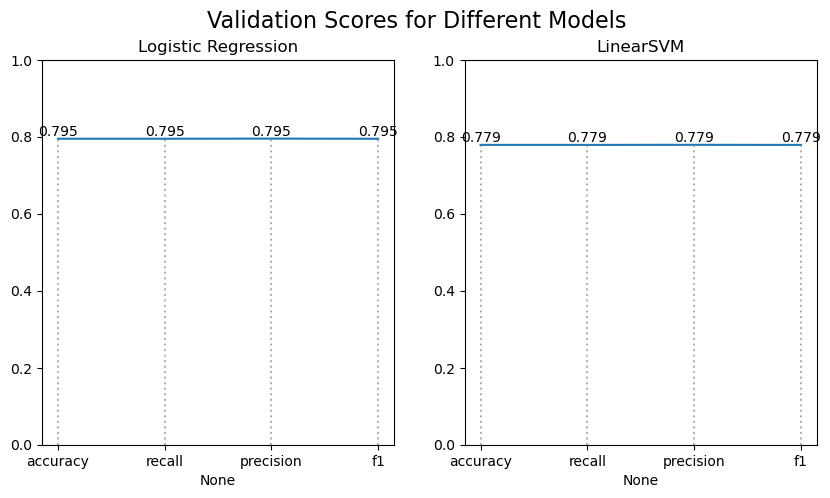

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.4)
for i, (name, model) in enumerate(models.items()):
    ax = fig.add_subplot(1, 2, i+1)
    model.fit(X_train_preprocessed, y_train)
    train_res = pd.Series(hf.get_scores(model, X_train_preprocessed, y_train, fit=False))
    res = pd.Series(hf.get_scores(model, X_val_preprocessed, y_val, fit=False))
    sns.lineplot(x=res.index, y=res.values)
    ax.set_ylim(0, 1)
    ax.set_title(name)
    for x_coor in res.index:
        y_corr = res.loc[x_coor]
        ax.text(x_coor, y_corr, round(y_corr, 3), ha='center', 
                        va='bottom', fontsize=10)
        ax.vlines(x_coor, ymin=0, ymax=y_corr, colors='gray', 
                        linestyles='dotted', alpha=0.6)
        
plt.suptitle("Validation Scores for Different Models", fontsize=16);

Both models show pretty descent results. Logistic Regression is best. Its accuracy is more than 79%, while Linear SVM is 1% worse.

### LSTM

We will build a Long Short-Term Memory (LSTM) model using GloVe embeddings trained on tweets with 200 dimensions. To better capture the context in tweets, we will utilize a Bidirectional LSTM. The vocabulary size will be set to 50,000 words.

**Load the embedding and create an embedding matrix**

In [11]:
embeddings_index = hf.load_glove_embeddings('../models/glove.twitter.27B.200d.txt')

vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train["preprocessed_text"])

sequences_train = tokenizer.texts_to_sequences(X_train["preprocessed_text"])
sequences_val = tokenizer.texts_to_sequences(X_val["preprocessed_text"])

max_length = max([len(seq) for seq in sequences_train])

X_train_padded = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(sequences_val, maxlen=max_length, padding='post')

embedding_dim = 200  
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

**Build the model**

We will use Early Stopping to prevent overfitting.

In [12]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy', Precision(), Recall(), AUC()])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,  
    verbose=1,            
    restore_best_weights=True);

In [13]:
y_train = y_train.replace({"positive": 1, "negative": 0})
y_val = y_val.replace({"positive": 1, "negative": 0})

**Train the model**

In [14]:
# lstm_model.fit(X_train_padded, y_train,
#             validation_data=(X_val_padded, y_val),
#             epochs=20, batch_size=64, callbacks=[early_stopping])

lstm_model.load_weights("../models/lstm_model.h5")
loss, accuracy, precision, recall, roc_auc = lstm_model.evaluate(X_val_padded, y_val)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

2363/2363 [==============================] - 26s 11ms/step - loss: 0.4369 - accuracy: 0.7962 - precision: 0.8009 - recall: 0.7883 - auc: 0.8786
Accuracy: 0.7961742877960205
Precision: 0.8008818626403809
Recall: 0.7882508635520935
ROC AUC: 0.8785994052886963


The results are pretty good. We have 79.6% of accuracy. However, considering that Logistic Regression has almost the same performance while took significantly less time to train, our expectations were higher.

**Evaluation on the test set**

LSTM:

In [15]:
sequences_test = tokenizer.texts_to_sequences(test_data["preprocessed_text"])
X_test_padded = pad_sequences(sequences_test, maxlen=max_length, padding='post')
y_test = test_data["sentiment"]
y_test = y_test.replace({"positive": 1, "negative": 0})

loss, accuracy, precision, recall, roc_auc = lstm_model.evaluate(X_test_padded, y_test)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

2487/2487 [==============================] - 28s 11ms/step - loss: 0.4333 - accuracy: 0.7988 - precision: 0.8018 - recall: 0.7938 - auc: 0.8807
Accuracy: 0.7987709641456604
Precision: 0.8017771244049072
Recall: 0.7937768697738647
ROC AUC: 0.880732536315918


Logistic Regression:

In [16]:
X_test_preprocessed = vectorizer.transform(test_data["preprocessed_text"])
preds = pd.Series(models["Logistic Regression"].predict(X_test_preprocessed))
probas = models["Logistic Regression"].predict_proba(X_test_preprocessed)[:, 1]

preds = preds.replace({"positive": 1, "negative": 0})

print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"ROC AUC: {roc_auc_score(y_test, probas)}")

Accuracy: 0.7944606413994169
Precision: 0.7844051173743112
Recall: 0.8121245632995702
ROC AUC: 0.8746620761713606


The results of both models are identical to their performance on the validation data.

**Our final approach will be to fine-tune Bert model**

### Bert

**Tokenize the text**

In [6]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# X_train_encodings = tokenizer(list(X_train["preprocessed_text"]), 
#                    max_length=128, 
#                    padding='max_length', 
#                    truncation=True, return_tensors="tf")
# X_val_encodings = tokenizer(list(X_val["preprocessed_text"]), 
#                    max_length=128, 
#                    padding='max_length', 
#                    truncation=True, return_tensors="tf")

We are training the model for 3 epochs with a batch size of 64. We reserve 10% of the total training steps for a warm-up phase, where the learning rate gradually increases. The optimizer is then created with an initial learning rate of 1e-5.

In [7]:
# epochs = 3
# batch_size = 64

# batches_per_epoch = len(y_train) // batch_size

# num_train_steps = int(batches_per_epoch * epochs)
# num_warmup_steps = int(0.1 * num_train_steps)

# optimizer, lr_schedule = create_optimizer(
#     init_lr=1e-5,
#     num_train_steps=num_train_steps,
#     num_warmup_steps=num_warmup_steps
# )

**Model Setup and Training**

We initialize a BERT model for sequence classification (TFBertForSequenceClassification) using the pre-trained 'bert-base-uncased' model. We set the number of output labels to 1 for binary classification and specify dropout rates of 0.2 to help prevent overfitting.

We also include evaluation metrics such as accuracy, ROC AUC, Recall, and Precision to track performance during training.

In [8]:
# bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', 
#                                                              num_labels=1,
#                                                              attention_probs_dropout_prob=0.2, 
#                                                              hidden_dropout_prob=0.2)

# bert_model.compile(optimizer=optimizer, 
#                    loss="BinaryCrossentropy",
#                    metrics=["accuracy", 'AUC', 'Recall', 'Precision'])

# history = bert_model.fit([X_train_encodings['input_ids'],
#                           X_train_encodings['token_type_ids'], 
#                           X_train_encodings['attention_mask']],
#                          y_train,
#                          validation_data=([X_val_encodings['input_ids'], 
#                                            X_val_encodings['token_type_ids'],
#                                            X_val_encodings['attention_mask']],y_val),
#                          batch_size=batch_size,epochs=epochs)

bert_model = TFBertForSequenceClassification.from_pretrained('../models/sentiment_bert_model')
tokenizer = BertTokenizer.from_pretrained('../models/sentiment_bert_model')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../models/sentiment_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


**Evaluation on the test set**

In [22]:
# bert_predictions = get_predictions(test_data, bert_model, tokenizer)
bert_predictions = np.load("../models/bert_predictions.npy")
bert_label_preds = (bert_predictions > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, bert_label_preds)}")
print(f"Precision: {precision_score(y_test, bert_label_preds)}")
print(f"Recall: {recall_score(y_test, bert_label_preds)}")
print(f"ROC AUC: {roc_auc_score(y_test, bert_predictions)}")

Accuracy: 0.7967603297476626
Precision: 0.7806779822184187
Recall: 0.8253952295976072
ROC AUC: 0.8797522300734814


The result on the test set is decent. However, it is slightly worse than LSTM and almost the same as Logistic Regression. Considering the training time required for the model, the BERT model is definitely not the most effective choice for this project.

# Conclusion
After training different models, here are the results of the best ones:
* Logistic Regression:
    * Accuracy: 0.7987709641456604
    * Precision: 0.8017771244049072
    * Recall: 0.7937768697738647
    * ROC AUC: 0.880732536315918
* Long Short-Term Memory:
    * Accuracy: 0.7944606413994169
    * Precision: 0.7844051173743112
    * Recall: 0.8121245632995702
    * ROC AUC: 0.8746620761713606
* Bert transformer:
    * Accuracy: 0.7967603297476626
    * Precision: 0.7806779822184187
    * Recall: 0.8253952295976072
    * ROC AUC: 0.8797522300734814

While all models delivered decent results, Logistic Regression was the most efficient in terms of both training time and prediction speed compared to LSTM and BERT. The BERT Transformer model could potentially be enhanced by adding additional layers or training for more epochs, though this would significantly increase computation time.


# 